<a href="https://colab.research.google.com/github/Dkepffl/2022-1-ESAA/blob/main/Assignment220905_trianing_model_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **캐글 실습 필사 : Stacked Regressions : Top 4% on LeaderBoard**
___
출처 : https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard/notebook

In [1]:
# import package

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew # for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # Limiting floats output to 3 decimal points

### | **데이터 로드 및 데이터 확인**
___

In [6]:
# import Data
train = pd.read_csv('/content/drive/MyDrive/2022-2 ESAA/Data/House_Price/train.csv')
test = pd.read_csv('/content/drive/MyDrive/2022-2 ESAA/Data/House_Price/test.csv')

In [7]:
# display the first five rows of the train dataset
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
#display the first five rows of the test dataset.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
# check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


- 위에서는 `shape()` 메서드를 이용했는데, `info()` 메서드를 이용해서 데이터 형태나 컬럼별 데이터 타입 등에 대해 살펴봐도 좋을 듯
- `train` 데이터셋에서는 타겟값인 `SalePrice` 컬럼이 존재한다.
- 이제 `id` 컬럼을 따로 저장하고, 데이터셋에서 `id` 컬럼을 삭제해보자.

In [10]:
# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

- `id` 컬럼을 드랍한 후, 데이터 크기를 다시 확인해보자.

In [12]:
# check again the data size after dropping the 'Id' variable
print("The train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


### | **Data Processing(데이터 전처리)**
___

#### **Outliers(이상치)**

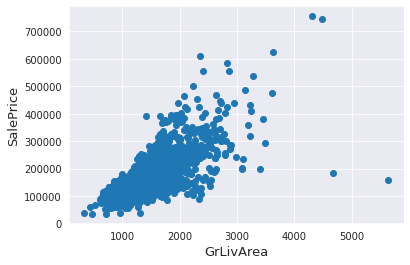

In [13]:
fig, ax = plt.subplots()

# scatter plot
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])

# set label
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

plt.show()

- 우측 하단에 `GrLivArea` 값은 매우 크지만, `SalePrice`는 매우 작은 두 이상치를 확인할 수 있다.
- 두 이상치를 제거하고, 다시 그래프를 확인해보자.

In [14]:
# Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

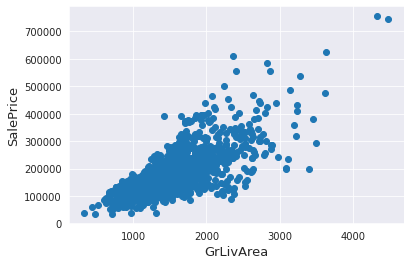

In [15]:
# Check the graphic again
fig, ax = plt.subplots()

ax.scatter(train['GrLivArea'], train['SalePrice'])

plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

plt.show()

- 이상치를 제거하는 것이 항상 좋은 것은 아니다. 
- 여기서는 두 값이 매우 크고 실제로 모델에 나쁜 영향을 끼치는 것을 확인했기 때문에 제거하였다. 

#### **Target Variable(타겟값)**
- `SalePrice`는 예측해야 할 타겟값이다. 따라서 분석을 통해 해당 변수에 대해 좀 더 알아보도록 하자.

In [16]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

mu = 180932.92 and sigma = 79467.79


Text(0.5, 1.0, 'SalePrice distribution')

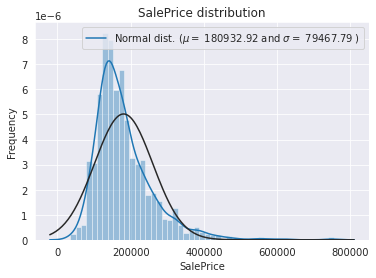

In [17]:
sns.distplot(train['SalePrice'] , fit=norm) # distribution을 표현

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

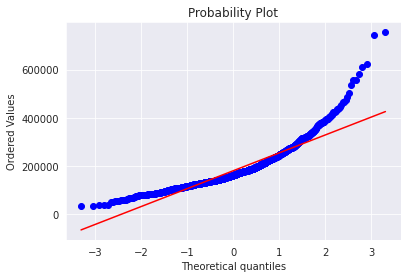

In [18]:
# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- 타겟값의 분포가 right skewed 되어 있다. 
  + A distribution is **left skewed** if it has a tail on the left side of the distribution
  + A distribution is **right skewed** if it has a tail on the right side of the distribution:
- 선형 모델은 정규 분포인 데이터를 좋아하기 때문에, 데이터의 분포를 변환해주어야 한다.
- 로그 변환을 통해, 왜곡된 데이터의 분포를 바로 잡아 보자.

In [20]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

In [22]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

mu = 12.02 and sigma = 0.40


Text(0.5, 1.0, 'SalePrice distribution')

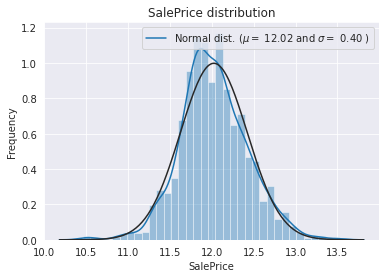

In [24]:
# Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

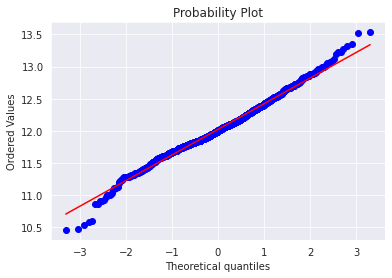

In [23]:
# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- 왜곡되어 있던 데이터의 분포가 로그 변환 후, 정규 분포 형태를 띄고 있다.

#### **Features engineering**

In [25]:
ntrain = train.shape[0]
ntest = test.shape[0]

# 타겟값 저장
y_train = train.SalePrice.values

# train과 test 데이터를 합쳐 전체 데이터셋을 만듦
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True) # 타겟값 제거/전체 데이터셋에서 피처만 남음
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


##### **Missing Value**
___
- 각 컬럼별 Missing Value의 비율을 확인해보자.

In [26]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100 #  Missing Value의 비율 계산
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30] # Missing Value가 없는 컬럼은 제거
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

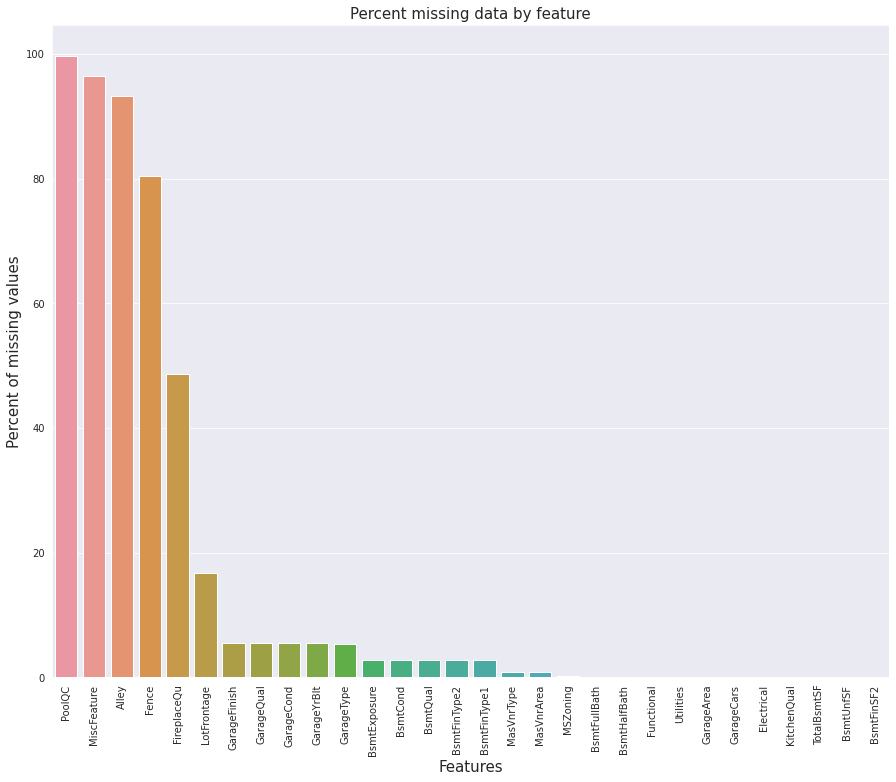

In [27]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')

sns.barplot(x=all_data_na.index, y=all_data_na)

plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)